In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.forecasting.theta import ThetaModel
from sklearn.metrics import mean_absolute_percentage_error

In [315]:
df = pd.read_csv('hierarchial_forecasting.csv')
df.head(5)

,date,ice_skates,sunglasses,total
0,31/01/2021,61,11,72
1,28/02/2021,58,9,67
2,31/03/2021,55,25,80
3,30/04/2021,49,34,83
4,31/05/2021,35,45,80


In [316]:
df.shape

(48, 4)

In [317]:
# převedeme Month na datetime (kdyby náhodou nebyl)
df["date"] = pd.to_datetime(df["date"],  format="%d/%m/%Y")
df.head(5)

,date,ice_skates,sunglasses,total
0,2021-01-31,61,11,72
1,2021-02-28,58,9,67
2,2021-03-31,55,25,80
3,2021-04-30,49,34,83
4,2021-05-31,35,45,80


In [318]:
df["month"] = df["date"].dt.month
df.head(5)

,date,ice_skates,sunglasses,total,month
0,2021-01-31,61,11,72,1
1,2021-02-28,58,9,67,2
2,2021-03-31,55,25,80,3
3,2021-04-30,49,34,83,4
4,2021-05-31,35,45,80,5


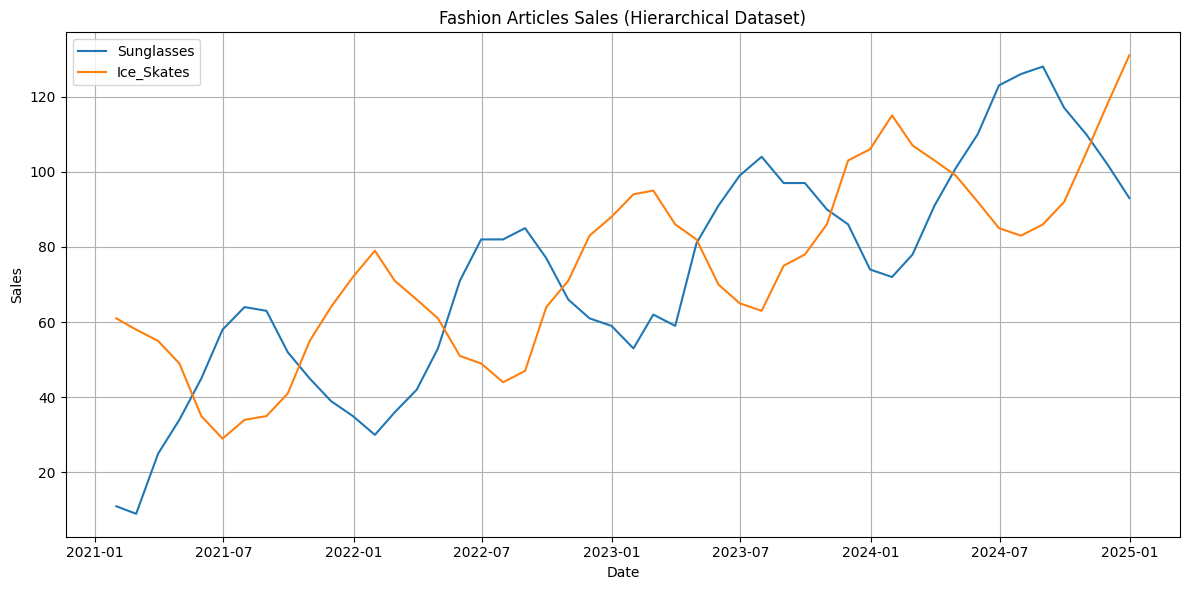

In [319]:
# vykreslení tří artiklů
plt.figure(figsize=(12,6))
plt.plot(df["date"], df["sunglasses"], label="Sunglasses")
plt.plot(df["date"], df["ice_skates"], label="Ice_Skates")

# volitelně i celkový součet
#plt.plot(df["Month"], df["Total"], label="Total", linewidth=2, linestyle="--", color="black")

plt.title("Fashion Articles Sales (Hierarchical Dataset)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Predict total

### Train/test split

In [320]:
# Lat 12 months
train = df.iloc[:-12]
test = df.iloc[-12:]

In [321]:
fh = len(test)

### Fit model

In [322]:
# Fit the model
model = ThetaModel(train['total'], period=12)   
res = model.fit()

### Base Forecast

In [323]:
forecast_total = res.forecast(fh)
forecast_total = forecast_total.to_numpy()

forecast_total

array([182.93717744, 184.56613497, 186.1950925 , 187.82405003,
       189.45300756, 191.08196509, 192.71092262, 194.33988014,
       195.96883767, 197.5977952 , 199.22675273, 200.85571026])

### MAPE

In [324]:
mape = round(mean_absolute_percentage_error(test['total'], forecast_total) * 100, 2)
mape


6.5

# Reconsiliation - TOP -> DOWN

In [325]:
# Seasonal proportions
props = train[["ice_skates","sunglasses"]].div(train["total"], axis=0)

# Mean for all years
seasonal_props = props.groupby(train['month']).mean().reset_index()
seasonal_props

,month,ice_skates,sunglasses
0,1,0.737150,0.262850
1,2,0.711440,0.288560
2,3,0.630572,0.369428
3,4,0.542839,0.457161
4,5,0.430105,0.569895
5,6,0.367907,0.632093
6,7,0.357797,0.642203
7,8,0.383083,0.616917
8,9,0.446825,0.553175
9,10,0.518962,0.481038


In [326]:
# Coeffs into the numpy
ice_prop = seasonal_props['ice_skates'].to_numpy()
sun_prop = seasonal_props['sunglasses'].to_numpy()

In [327]:
# TOP-DOWN reconsiliation
forecast_df = pd.DataFrame({
    "month": test.index,
    "total_actual": test["total"].values,
    "total_forecast": forecast_total,                 # Series z ThetaModelu

    "ice_skates_actual": test["ice_skates"].values,
    "ice_skates_forecast": forecast_total * ice_prop, # SEZÓNNÍ podíly

    "sunglasses_actual": test["sunglasses"].values,
    "sunglasses_forecast": forecast_total * sun_prop  # SEZÓNNÍ podíly
})

forecast_df

,month,total_actual,total_forecast,ice_skates_actual,ice_skates_forecast,sunglasses_actual,sunglasses_forecast
0,36,187,182.937177,115,134.852058,72,48.085120
1,37,185,184.566135,107,131.307644,78,53.258491
2,38,194,186.195092,103,117.409322,91,68.785770
3,39,200,187.824050,99,101.958198,101,85.865852
4,40,202,189.453008,92,81.484711,110,107.968297
5,41,208,191.081965,85,70.300367,123,120.781598
6,42,209,192.710923,83,68.951366,126,123.759556
7,43,214,194.339880,86,74.448367,128,119.891513
8,44,209,195.968838,92,87.563790,117,108.405048
9,45,215,197.597795,105,102.545651,110,95.052144


In [328]:
mape_ice_skates = round(mean_absolute_percentage_error(forecast_df['ice_skates_actual'], forecast_df['ice_skates_forecast']) * 100, 2) 
mape_ice_skates

10.84

In [329]:
mape_ice_skates = round(mean_absolute_percentage_error(forecast_df['sunglasses_actual'], forecast_df['sunglasses_forecast']) * 100, 2) 
mape_ice_skates

14.43

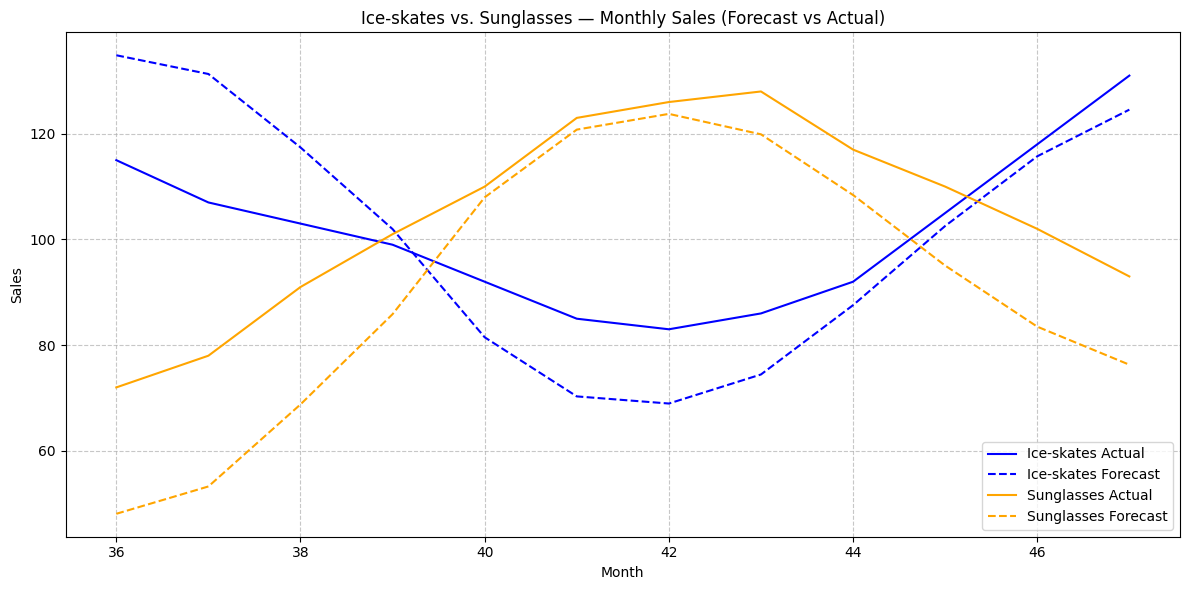

In [330]:
plt.figure(figsize=(12,6))

# Ice-skates
plt.plot(forecast_df["month"], forecast_df["ice_skates_actual"], 
         label="Ice-skates Actual", color="blue")
plt.plot(forecast_df["month"], forecast_df["ice_skates_forecast"], 
         label="Ice-skates Forecast", color="blue", linestyle="--")

# Sunglasses
plt.plot(forecast_df["month"], forecast_df["sunglasses_actual"], 
         label="Sunglasses Actual", color="orange")
plt.plot(forecast_df["month"], forecast_df["sunglasses_forecast"], 
         label="Sunglasses Forecast", color="orange", linestyle="--")

plt.title("Ice-skates vs. Sunglasses — Monthly Sales (Forecast vs Actual)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Reconsiliation - DOWN -> TOP

In [331]:
# Fit the model
model_ice = ThetaModel(train['ice_skates'], period=12)   
res_ice = model_ice.fit()

# Fit the model
model_sun = ThetaModel(train['sunglasses'], period=12)   
res_sun = model_sun.fit()

In [332]:
forecast_ice = res_ice.forecast(fh)
forecast_sun = res_sun.forecast(fh)

forecast_ice = forecast_ice.to_numpy()
forecast_sun = forecast_sun.to_numpy()

In [333]:
mape_ice = round(mean_absolute_percentage_error(test['ice_skates'], forecast_ice) * 100, 2)
mape_sun = round(mean_absolute_percentage_error(test['sunglasses'], forecast_sun) * 100, 2)

print(mape_ice)
print(mape_sun)

14.97
21.67


In [334]:
# TOP-DOWN reconsiliation
forecast_df = pd.DataFrame({
    "month": test.index,

    "total_actual": test["total"].values,
    "total_forecast": forecast_total, 

    "ice_skates_actual": test["ice_skates"].values,
    "ice_skates_forecast": forecast_ice, 

    "sunglasses_actual": test["sunglasses"].values,
    "sunglasses_forecast": forecast_sun  
})

forecast_df

,month,total_actual,total_forecast,ice_skates_actual,ice_skates_forecast,sunglasses_actual,sunglasses_forecast
0,36,187,182.937177,115,106.677792,72,74.952405
1,37,185,184.566135,107,107.355849,78,75.903306
2,38,194,186.195092,103,108.033905,91,76.854207
3,39,200,187.824050,99,108.711962,101,77.805108
4,40,202,189.453008,92,109.390019,110,78.756008
5,41,208,191.081965,85,110.068075,123,79.706909
6,42,209,192.710923,83,110.746132,126,80.657810
7,43,214,194.339880,86,111.424188,128,81.608711
8,44,209,195.968838,92,112.102245,117,82.559612
9,45,215,197.597795,105,112.780302,110,83.510513


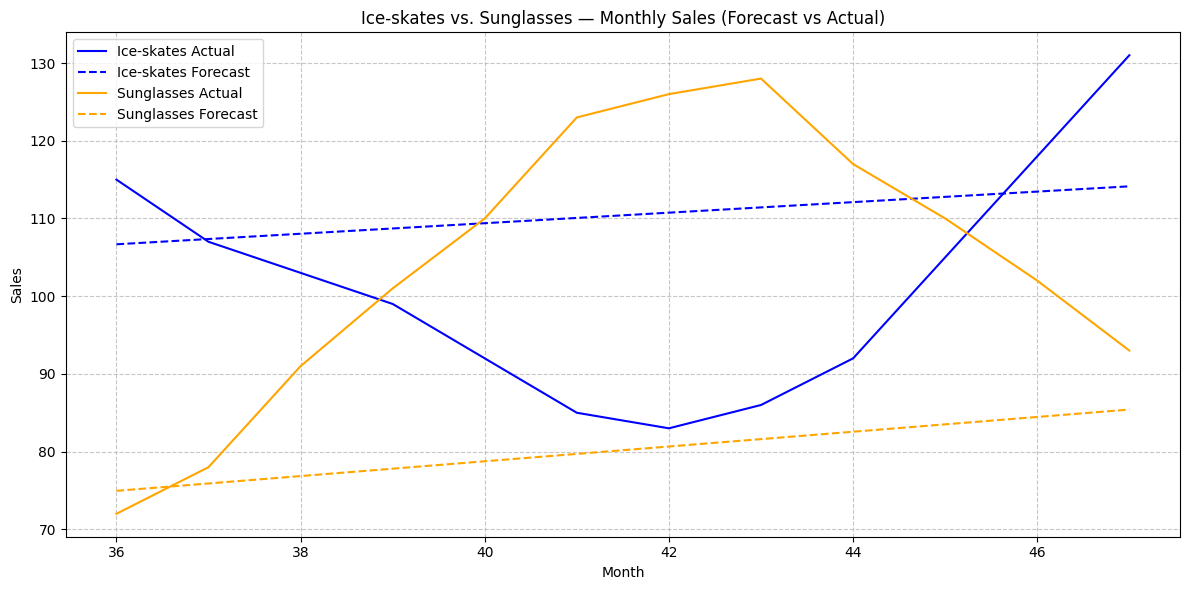

In [335]:
plt.figure(figsize=(12,6))

# Ice-skates
plt.plot(forecast_df["month"], forecast_df["ice_skates_actual"], 
         label="Ice-skates Actual", color="blue")
plt.plot(forecast_df["month"], forecast_df["ice_skates_forecast"], 
         label="Ice-skates Forecast", color="blue", linestyle="--")

# Sunglasses
plt.plot(forecast_df["month"], forecast_df["sunglasses_actual"], 
         label="Sunglasses Actual", color="orange")
plt.plot(forecast_df["month"], forecast_df["sunglasses_forecast"], 
         label="Sunglasses Forecast", color="orange", linestyle="--")

plt.title("Ice-skates vs. Sunglasses — Monthly Sales (Forecast vs Actual)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Conclusion

In [348]:
''' 
- TOP->DOWN approcah is easier than DOWN->TOP approach
- TOP->DOWN approach has lower MAPE for both products compared to the DOWN->TOP approach.

'''

' \n- TOP->DOWN approcah is easier than DOWN->TOP approach\n- TOP->DOWN approach has lower MAPE for both products compared to the DOWN->TOP approach.\n\n'